In [1]:
# Import libraries
using Turing
using LinearAlgebra
using Distributions
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using StatsBase
using Statistics
using Suppressor
using JLD2
using CSV
using DataFrames, DataFramesMeta
using SplitApplyCombine
using KernelFunctions
using MCMCChains
using PyCall
using PyPlot
using Printf
import PyCall.pyfunction
using Optim

include("../Utils/scale_utils.jl")
using .ScaleUtils

include("../Utils/gp_utils.jl")
using .GPUtils

# Access the matplotlib module
matplotlib = pyimport("matplotlib")
seaborn = pyimport("seaborn")
os = pyimport("os")
pyimport("scienceplots")
np = pyimport("numpy")
scipy = pyimport("scipy")
skl_model_selection = pyimport("sklearn.model_selection")
plt.style.use(["default","science","no-latex"])
using StatsPlots

seaborn.color_palette("colorblind")

PyCall.pygui(:tk)

# Set a seed for reproducibility
using Random
Random.seed!(11);

#import Pkg
#Pkg.add("PrettyTables")
FONTSIZE=20.5;

In [2]:
function plot_slr_means_of_trajectory(path_to_proj, axis, r, pred_year, color, fill_color)
    
    # Years at which recalibration occurred
    cal_years = collect(range(2015, step=15, length=20))
    # @show cal_years
    # Maximum number of calibration years that occurred before year projected
    n_cal_years = fld(pred_year-2015,15) + 1
    
    means = Vector{Float64}()
    uppers = Vector{Float64}()
    lowers = Vector{Float64}()
    
    # Index of the matrix containing the specified years projections
    pred_idx = yrs_dict[pred_year]

    sample_post_mm_ssp5_2015 = JLD2.load("../Data/Projection_Data/2015_SLR_Projections.jld2", "present2015_post_mm_ssp5")

    push!(means, mean(sample_post_mm_ssp5_2015[pred_idx,:] ))
    push!(uppers, quantile(sample_post_mm_ssp5_2015[pred_idx,:], 0.95))
    push!(lowers, quantile(sample_post_mm_ssp5_2015[pred_idx,:], 0.05))
    
    for yr in cal_years[2:n_cal_years]
        current_projections = JLD2.load("$(path_to_proj)/$(r)-year$(yr)pred_VAF.jld2","sample_post_mm_ssp5" )
        # Calculate the means and quantiles of that row 
        push!(means, mean( current_projections[pred_idx,:] ))
        push!(uppers, quantile(current_projections[pred_idx,:], 0.95))
        push!(lowers, quantile(current_projections[pred_idx,:], 0.05))

    end
    # Plot against year calibrated
    axis.plot(cal_years[1:n_cal_years], means, label="Projection distribution mean",zorder=20, color=color, lw=3)
    axis.fill_between(cal_years[1:n_cal_years], uppers, lowers,alpha=0.5, label="90% Credible interval", color=fill_color)
    axis.set_xlim(2015,cal_years[n_cal_years])
    xticks = (pred_year == 2300) ? [2015,2050,2100,2150,2200,2250,2300] : cal_years[1:1+floor(Int,pred_idx/100):n_cal_years]
    axis.set_xticks(xticks)
    axis.tick_params(axis="both", which="major", labelsize=FONTSIZE)
    axis.grid(true, alpha=0.25, zorder=1)
    axis.set_xlabel("Year of last observation", fontsize=FONTSIZE, labelpad=10)
    axis.set_ylabel("Sea level contribution at $(pred_year) (mm)", fontsize=FONTSIZE, labelpad=10)
    
end

plot_slr_means_of_trajectory (generic function with 1 method)

In [3]:
#Loading original parameter data for scaling purposes
X_raw = CSV.read("../Data/Training_Data/Amery_Input_Parameters_Filtered.csv", DataFrame);
# 1) Grab all column‐names as Symbols
cols = Symbol.(names(X_raw))
# 2) Remove the index‐column symbol
cols = filter(c -> c != :Column1, cols)
# 3) Now call get_scaled_matrix on the remaining columns
X_scaled_t, X_scalers, X_mins, X_maxs = ScaleUtils.get_scaled_matrix(X_raw, cols);

In [4]:
function unscale_params(params)
    
    unscaled_θ_1 = ( params[1] * (X_maxs[:vmThresh] - X_mins[:vmThresh]) ) + X_mins[:vmThresh]
    unscaled_θ_2 = ( params[2] * (X_maxs[:fricExp] - X_mins[:fricExp]) ) + X_mins[:fricExp]
    unscaled_θ_3 = ( params[3] * (X_maxs[:mu_scale] - X_mins[:mu_scale]) ) + X_mins[:mu_scale]
    unscaled_θ_4 = ( params[4] * (X_maxs[:stiff_scale] - X_mins[:stiff_scale]) ) + X_mins[:stiff_scale]
    unscaled_θ_5 = ( params[5] * (X_maxs[:gamma0] - X_mins[:gamma0]) ) + X_mins[:gamma0]
    unscaled_θ_6 = ( params[6] * (X_maxs[:melt_flux] - X_mins[:melt_flux]) ) + X_mins[:melt_flux];
    unscaled_thetas = [unscaled_θ_1
                        unscaled_θ_2
                        unscaled_θ_3
                        unscaled_θ_4
                        unscaled_θ_5
                        unscaled_θ_6];
    return unscaled_thetas
    
end

unscale_params (generic function with 1 method)

In [5]:
#Realization numbers
Realizations = [string(i) for i in 1:100];


future_obs_directory = "../Data/Future_Observation_Data/Generative_Parameters/Official_Constraining_Observations-metadata"
θ_mat  = Array{Float64}(undef, length(Realizations), 6)

for (i, r) in enumerate(Realizations)
    θ = JLD2.load(joinpath(future_obs_directory, "$(r)_emulator_data.jld2"), "θ")
    θ_mat[i, :] = unscale_params(θ)            # ensure this returns a 6-vector
end

In [6]:


# Random.seed!(7);
# # Only selecting 3 trajectories because the graph gets to messy with more.
# selections = [14,24,49,77]
# println(selections)
# years_predicted = [2100, 2200, 2300]

# path_to_posteriors = "../Data/Posterior_Data"
# path_to_slr_projections = "../Data/Projection_Data"


# title_dict = Dict([
#             1 => L"\sigma_{max}", 2 => L"q" , 3 => L"C_{\mu}" ,
#             4 => L"C_{\phi}", 5 => L"log(\gamma_0)", 6 => L"\overline{m}" ])

# tick_dict  = Dict(1=>[100000,120000,140000],
#                   2=>[0.15,0.20,0.25,0.30],
#                   3=>[0.8,0.9,1,1.1],
#                   4=>[0.8,0.9,1],
#                   5=>[9.17,10,11,12],
#                   6=>[20,30,40,50])

# ylim_dict = Dict([1 => [0.98e5,1.5e5], 
#                   2 => [0.093,0.34], 
#                   3 => [0.79,1.14],
#                   4 => [0.79,1.08], 
#                   5 => [9.05,12.2], 
#                   6 => [11.5,58.5]])

# color_dict = Dict(
#                 1 => "red", 2=> "green", 3=>"purple", 4=>"blue"
# )

# fill_color_dict = Dict(
#                 1 => "lightcoral", 2=> "palegreen", 3=>"plum", 4=>"lightblue"
# )

# # Generic handles and labels for the figures
# gray_patch = matplotlib.patches.Patch(color="gray", label="90% credible interval",alpha=0.5)
# black_line_param = matplotlib.lines.Line2D([], [], lw=3, color="black", label="Parametric distribution mean")
# black_line_slr = matplotlib.lines.Line2D([], [], lw=3, color="black", label="Projection distribution mean")

# # Define the figure subplots for parametric analysis
# fig_params, ax_params = PyPlot.subplots(nrows=6, ncols=1, figsize=(15, 22), dpi=300,
#                      gridspec_kw=Dict("height_ratios"=> [1, 1, 1, 1, 1, 1],"hspace"=> 0.3))

# # Loop to call the parametric plotting function 
# for (i,r) in enumerate(selections)
#     posterior_dict = JLD2.load("$(path_to_posteriors)/R_$(r)_Posterior_Dict.jld2", "post_data")
#     plot_param_means_of_trajectory(r, posterior_dict, ax_params, title_dict, tick_dict, ylim_dict, color_dict[i], fill_color_dict[i])
# end

# #Figure labels and legends
# ax_params[end].set_xlabel("Year of last observation", fontsize=FONTSIZE, labelpad=10)
# # fig_params.supylabel("Parameter value", fontsize=FONTSIZE)
# fig_params.legend(handles=[black_line_param, gray_patch],loc="upper center", ncol=6, fontsize=0.75*FONTSIZE,
#            bbox_to_anchor=(0.512, 0.93), bbox_transform=PyPlot.gcf().transFigure,
#            frameon="True", framealpha=1)
# param_plot_saveout_path = "../Plots/Figure_Three_Plots/param_means_vs_cal_year_test.pdf"
# mkpath(dirname(param_plot_saveout_path))
# #fig_params.savefig(param_plot_saveout_path; dpi=300)


# # Loop to call the SLR plotting function for projections for three future years
# for yr in years_predicted
#     slr_plot_saveout_path = "../Plots/Figure_Three_Plots/$(yr)_mean_slr_against_cal_year_test.pdf"
    
#     fig_slr, ax_slr = PyPlot.subplots(nrows=1, ncols=1, figsize=(18, 11), dpi=300,
#                      gridspec_kw=Dict("height_ratios"=> [1], "width_ratios" => [1]))
    
#     for (i,r) in enumerate(selections)
#         plot_slr_means_of_trajectory("$(path_to_slr_projections)/R_$(r)", ax_slr, r, yr, color_dict[i], fill_color_dict[i])
#     end
#     fig_slr.legend(handles=[black_line_slr, gray_patch],loc="upper center", ncol=6, fontsize=FONTSIZE,
#            bbox_to_anchor=(0.512, 1), bbox_transform=PyPlot.gcf().transFigure,
#            frameon="True", framealpha=1)
#     mkpath(dirname(slr_plot_saveout_path))
#     #fig_slr.savefig(slr_plot_saveout_path; bbox_inches="tight", dpi=300)
#     plt.close()
# end

In [13]:
present2015_post_mm_ssp5 = JLD2.load("../Data/Projection_Data/2015_SLR_Projections.jld2", "present2015_post_mm_ssp5");
θ_posterior_2015 = np.load("../Data/Training_Data/posterior_samples_All_Combined.npy");

In [14]:
function plot_param_means_of_trajectory(real, posterior_dict, axis, title_dict, tick_dict, ylim_dict, color, fill_color, fontsize_param)
    FONTSIZE = fontsize_param
    # Years at which recalibration occurred
    cal_years = collect(range(2015, step=15, length=19))
    means = Dict(j => Vector{Float64}() for j in 1:6)
    uppers = Dict(j => Vector{Float64}() for j in 1:6)
    lowers = Dict(j => Vector{Float64}() for j in 1:6)

    for j in 1:6
        current_post = θ_posterior_2015
        var = (j == 5) ? log.(current_post[:, j]) : current_post[:, j]
        push!(means[j], mean(var))
        push!(uppers[j], quantile(var, 0.95))
        push!(lowers[j], quantile(var, 0.05))
    end

    for yr in cal_years[2:end]
        current_post = posterior_dict[yr]
        for j in 1:6
            var = (j == 5) ? log.(current_post[:, j]) : current_post[:, j]
            push!(means[j], mean(var))
            push!(uppers[j], quantile(var, 0.95))
            push!(lowers[j], quantile(var, 0.05))
        end
    end

    for j in 1:6
        rI = (j-1) ÷ 2 + 1
        cI = (j-1) % 2 + 1
        ax = axis[rI, cI]
        # ax = axis[j]
        ax.spines["top"].set_visible(false)
        ax.spines["right"].set_visible(false)
        ax.tick_params(which="both", top=false, right=false, labeltop=false, labelright=false)
        ax.plot(cal_years,means[j],label="Parameter posterior distribution mean",zorder=20, color=color, lw=3)
        ax.fill_between(cal_years, uppers[j],lowers[j],alpha = 0.5,label="90% credible interval", color=fill_color)
        ax.ticklabel_format(style="sci", scilimits=(-2,4), useMathText=true)
        ax.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
        ax.xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
        ax.yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
        if rI == 3
            ax.set_xlabel("Analysis year", fontsize=FONTSIZE, labelpad=10)
        end
        ax.set_ylabel(title_dict[j], fontsize=FONTSIZE, labelpad=10)
        ax.set_yticks(tick_dict[j])
        ax.set_ylim(ylim_dict[j])
        ax.set_xlim(2015,2305)
        xticks = rI == 3 ? [2015,2050,2100,2150,2200,2250,2300] : []
        ax.set_xticks(xticks)
        # ax.locator_params(tight=true, nbins=6)
        ax.grid(true, alpha=0.25, zorder=1)

        y_true = (j == 5) ? log.(θ_mat[real, j]) : θ_mat[real, j]
        dx = 5        # small nudge to the right
        ax.scatter([cal_years[end]+dx], [y_true];
           marker="D", s=64, c=color, edgecolors="k", linewidths=0.8, zorder=21, clip_on=false)
    end  
end

plot_param_means_of_trajectory (generic function with 1 method)

In [15]:
all_years_no_gap = collect(range(2016, step=1, length=285))
yrs_gapped = collect(range(2030, step=15, length=19));

yrs_dict = Dict{Int64, Int64}()
for (idx,yr) in enumerate(all_years_no_gap)
        yrs_dict[yr] = idx
end

In [16]:
function plot_slr_means_of_trajectory(path_to_proj, axis, r, pred_year, color, fill_color, fontsize_slr)
    FONTSIZE = fontsize_slr
    # Years at which recalibration occurred
    cal_years = collect(range(2015, step=15, length=20))
    # @show cal_years
    # Maximum number of calibration years that occurred before year projected
    n_cal_years = fld(pred_year-2015,15) + 1
    
    means = Vector{Float64}()
    uppers = Vector{Float64}()
    lowers = Vector{Float64}()
    
    # Index of the matrix containing the specified years projections
    pred_idx = yrs_dict[pred_year]

    push!(means, mean(present2015_post_mm_ssp5[pred_idx,:] ))
    push!(uppers, quantile(present2015_post_mm_ssp5[pred_idx,:], 0.95))
    push!(lowers, quantile(present2015_post_mm_ssp5[pred_idx,:], 0.05))
    
    for yr in cal_years[2:n_cal_years]
        current_projections = JLD2.load("$(path_to_proj)/$(r)-year$(yr)pred_VAF.jld2","sample_post_mm_ssp5" )
        # Calculate the means and quantiles of that row 
        push!(means, mean( current_projections[pred_idx,:] ))
        push!(uppers, quantile(current_projections[pred_idx,:], 0.95))
        push!(lowers, quantile(current_projections[pred_idx,:], 0.05))

    end
    # Plot against year calibrated
    axis.plot(cal_years[1:n_cal_years], means, label="Projection distribution mean", zorder=20, color=color, lw=3)
    axis.fill_between(cal_years[1:n_cal_years], uppers, lowers,alpha=0.5, label="90% credible interval", color=fill_color)
    axis.set_xlim(2015,cal_years[n_cal_years])
    xticks = (pred_year == 2300) ? [2015,2050,2100,2150,2200,2250,2300] : cal_years[1:1+floor(Int,pred_idx/100):n_cal_years]
    axis.set_xticks(xticks)
    axis.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    axis.grid(true, alpha=0.25, zorder=1)
    axis.set_xlabel("Analysis year", fontsize=FONTSIZE, labelpad=10)
    axis.set_ylabel("Sea-level contribution at $(pred_year) (mm)", fontsize=FONTSIZE, labelpad=10)
end

plot_slr_means_of_trajectory (generic function with 2 methods)

[14, 24, 49, 77]


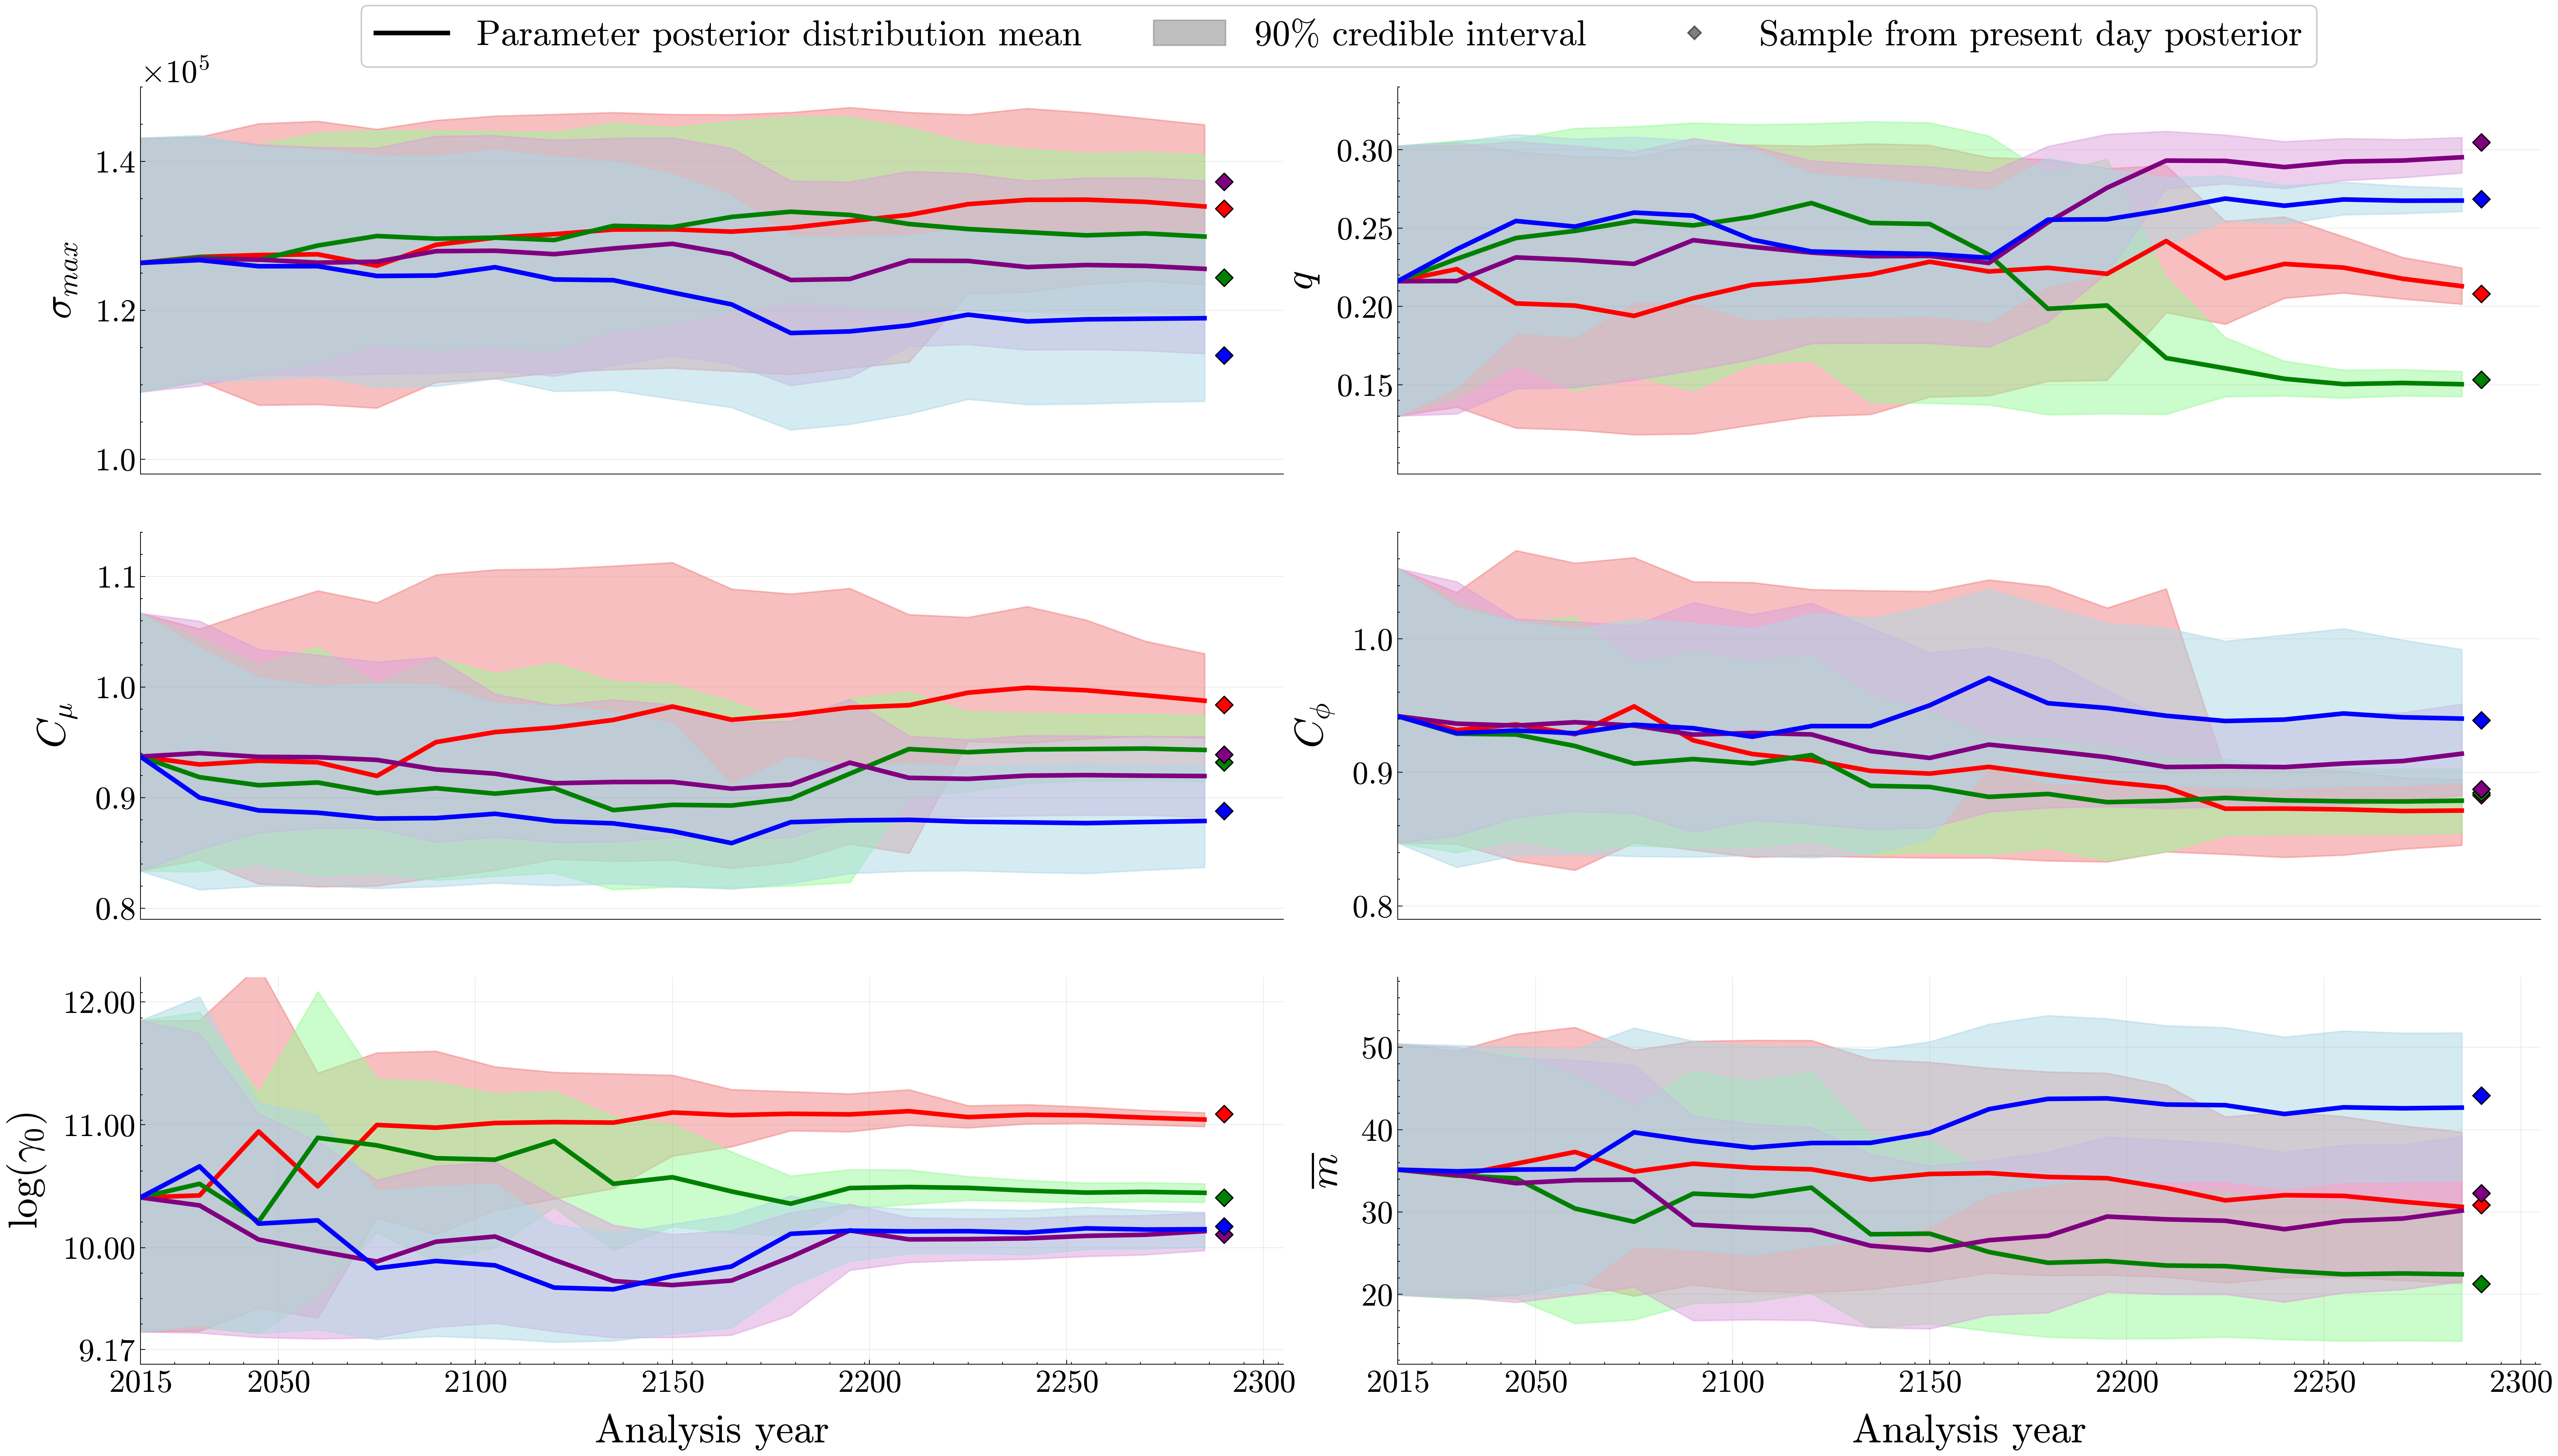

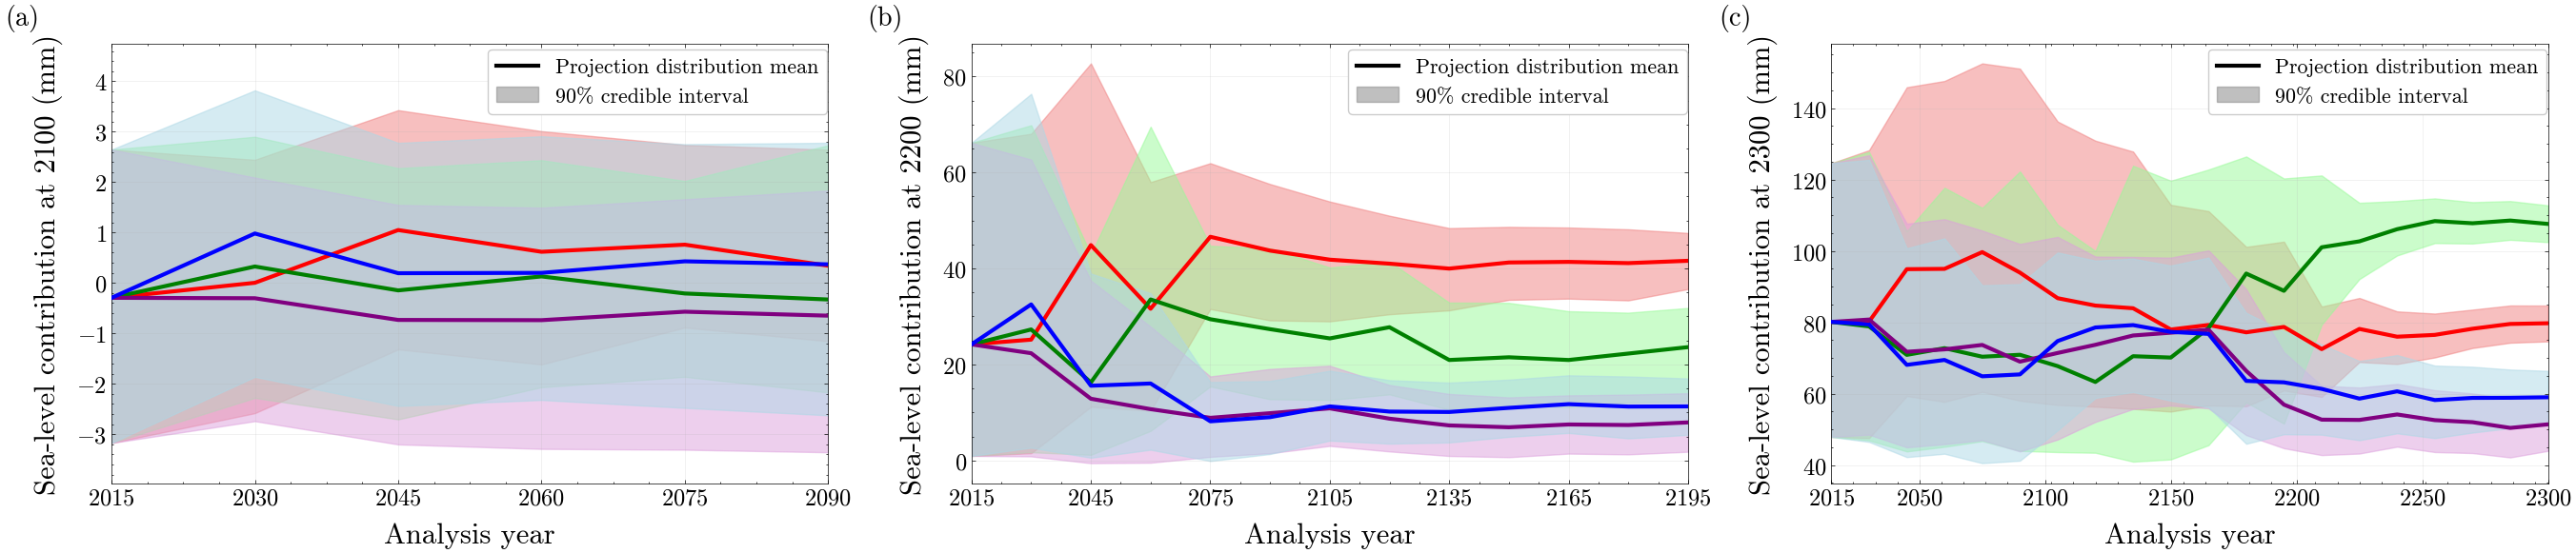

In [20]:
#Realization numbers
Realizations = [string(i) for i in 1:100];

Random.seed!(7);
# Only selecting 3 trajectories because the graph gets to messy with more.
selections = [14,24,49,77]
println(selections)

path_to_posteriors = "../Data/Posterior_Data"
path_to_slr_projections = "../Data/Projection_Data"


title_dict = Dict([
            1 => L"\sigma_{max}", 2 => L"q" , 3 => L"C_{\mu}" ,
            4 => L"C_{\phi}", 5 => L"\log(\gamma_0)", 6 => L"\overline{m}" ])

tick_dict  = Dict(1=>[100000,120000,140000],
                  2=>[0.15,0.20,0.25,0.30],
                  3=>[0.8,0.9,1,1.1],
                  4=>[0.8,0.9,1],
                  5=>[9.17,10,11,12],
                  6=>[20,30,40,50])

ylim_dict = Dict([1 => [0.98e5,1.5e5], 
                  2 => [0.093,0.34], 
                  3 => [0.79,1.14],
                  4 => [0.79,1.08], 
                  5 => [9.05,12.2], 
                  6 => [11.5,58.5]])

color_dict = Dict(
                1 => "red", 2=> "green", 3=>"purple", 4=>"blue"
)

fill_color_dict = Dict(
                1 => "lightcoral", 2=> "palegreen", 3=>"plum", 4=>"lightblue"
)

# Generic handles and labels for the figures
gray_patch = matplotlib.patches.Patch(color="gray", label="90% credible interval",alpha=0.5)
black_line_param = matplotlib.lines.Line2D([], [], lw=3, color="black", label="Parameter posterior distribution mean")
black_line_slr = matplotlib.lines.Line2D([], [], lw=3, color="black", label="Projection distribution mean")
diamond_marker = matplotlib.lines.Line2D([], [], marker="D", color="black",alpha=0.5,linestyle="None",label="Sample from present day posterior")

# Define the figure subplots for parametric analysis
fig_params, ax_params = PyPlot.subplots(nrows=3, ncols=2, figsize=(28, 15), dpi=300,
                     gridspec_kw=Dict("height_ratios"=> [1, 1, 1], "width_ratios"=> [1, 1], "hspace"=> 0.15, "wspace"=> 0.1))
FONTSIZE_PARAM = 26
# Loop to call the parametric plotting function 
for (i,r) in enumerate(selections)
    posterior_dict = JLD2.load("$(path_to_posteriors)/R_$(r)_Posterior_Dict.jld2", "post_data")
    plot_param_means_of_trajectory(r, posterior_dict, ax_params, title_dict, tick_dict, ylim_dict, 
                                    color_dict[i], fill_color_dict[i], FONTSIZE_PARAM)
end

#Figure labels and legends
ax_params[end].set_xlabel("Analysis year", fontsize=FONTSIZE_PARAM, labelpad=10)
# fig_params.supylabel("Parameter value", fontsize=FONTSIZE)
fig_params.legend(handles=[black_line_param, gray_patch,diamond_marker],loc="upper center", ncol=6,fontsize=0.9*FONTSIZE_PARAM,
           bbox_to_anchor=(0.512, 0.94), bbox_transform=PyPlot.gcf().transFigure,
           frameon="True", framealpha=1)
param_plot_saveout_path = "../Plots/Individual_Trajectory_Learning_Plots/param_posterior_against_analysis_year.pdf"
mkpath(dirname(param_plot_saveout_path))
fig_params.savefig(param_plot_saveout_path; dpi=300)
#plt.close()

fig_slr, axes = subplots(nrows=1, ncols=3, figsize=(33, 6))
fig_slr.subplots_adjust(wspace=0.2, hspace=0.0)
slr_plot_saveout_path = "../Plots/Individual_Trajectory_Learning_Plots/projected_slr_against_analysis_year.pdf"
FONTSIZE_SLR = 22
# Loop to call the SLR plotting function for projections for three future years
letters = ["a", "b", "c"]
for (a, chosen_year) in enumerate([2100, 2200, 2300])
    ax_slr = axes[a]
    for (i,r) in enumerate(selections)
        plot_slr_means_of_trajectory("$(path_to_slr_projections)/R_$(r)", ax_slr, r, chosen_year, color_dict[i], 
                                                                            fill_color_dict[i], FONTSIZE_SLR)
    end
    if a == 1
        ax_slr.set_ylim([-3.97,4.75])
    end
    if a == 3
        ax_slr.text(-0.157, 1.09, "(" * letters[a] * ")", ha="left", va="top", transform=ax_slr.transAxes, fontsize=FONTSIZE_SLR*0.92)
    elseif a == 2
        ax_slr.text(-0.145, 1.09, "(" * letters[a] * ")", ha="left", va="top", transform=ax_slr.transAxes, fontsize=FONTSIZE_SLR*0.92)
    else
        ax_slr.text(-0.149, 1.09, "(" * letters[a] * ")", ha="left", va="top", transform=ax_slr.transAxes, fontsize=FONTSIZE_SLR*0.92)
    end
    ax_slr.legend(handles=[black_line_slr, gray_patch],loc="upper center", ncol=1, fontsize=FONTSIZE_SLR*0.72,
           bbox_to_anchor=(0.762, 1.01),frameon="True", framealpha=1)
end
mkpath(dirname(slr_plot_saveout_path))
fig_slr.savefig(slr_plot_saveout_path; bbox_inches="tight", dpi=300)
#plt.close()